In [ ]:
!pip -q install 'transformers[torch]' shap evaluate pyarrow==15.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 15.0.2 which is incompatible.


In [ ]:
import shap
import torch
import evaluate
import numpy as np
import pandas as pd

from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
              Trainer, TrainingArguments, DataCollatorWithPadding, pipeline)

In [ ]:
dataset = pd.read_csv("golden_dataset4finetune.csv")
dataset.sample(3)

content  target type_queue  \
9865   Как найти версии 'Manchester by the Sea' Кенне...       0      input   
7950   Ваш вопрос о пиратских фильмах не является кор...       0     output   
14128  Что этот няшный пупс забыл в скотозагоне пропа...       1     output   

      type_toxic crossencoder  
9865   copyright          NaN  
7950   copyright          NaN  
14128      toxic          NaN

In [ ]:
dataset = dataset.query("(crossencoder.isna()) and (type_toxic != 'malware')")
print(dataset.shape[0])

23769


In [ ]:
data = dataset.sample(frac=1, random_state=42).content[:5].tolist()

In [ ]:
model_name = "apanc/russian-inappropriate-messages"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config = model.config
config.label2id = { "non-toxic": 0, "toxic": 1}
config.id2label = { 0: "non-toxic", 1: "toxic"}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/870 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/712M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/542 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Shap

In [ ]:
prediction = pipeline(
              "text-classification",
              model=model,
              tokenizer=tokenizer,
              return_all_scores=True,
)

result = prediction(data, max_length=50)
for x in range(len(data)):
  print(f"text: \n {data[x]} \n score: {result[x]}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


text: 
 Я норм зарабатываю. 70к в январе 40к в феврале. Просто порой не могу брать заказ, по состоянию здоровья. Зачем мне эта школа, если я за недельку поднять могу 50к ?
 
 score: [{'label': 'non-toxic', 'score': 0.9755674600601196}, {'label': 'toxic', 'score': 0.024432551115751266}]
text: 
 Ну уборка улиц от снега это уже неплохо . Не во всех городах даже это хорошо организовано. И предвыборные обещания выполнять это тоже гуд.
 
 score: [{'label': 'non-toxic', 'score': 0.9972482323646545}, {'label': 'toxic', 'score': 0.002751693595200777}]
text: 
 Подождите, весь смысл данного фундамента как раз в отсутствии таких сил. Как раз за счёт демпфера. Основание ниже уровня промерзания - здесь их нет. Касательных нет в силу демпфера. Нормальных нет в силу демпфера. (компенсация)
 
 score: [{'label': 'non-toxic', 'score': 0.9963060617446899}, {'label': 'toxic', 'score': 0.003693997161462903}]
text: 
 Где почитать книгу полностью? Читал в интернете но как то она непонятно оборвалась,на 64 дне

In [ ]:
explainer = shap.Explainer(prediction)
shap_values = explainer(data)
shap.plots.text(shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [02:26<01:03, 31.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [04:02<00:58, 58.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [04:57<00:00, 56.93s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [05:57, 71.43s/it]


# Train

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['content'], truncation=True, max_length=512)

dataset = dataset.rename(columns={"target": "labels"})
train_df, test_df = train_test_split(dataset, test_size=0.2, stratify=dataset.labels)
train_df, eval_df = train_test_split(dataset, test_size=0.2, stratify=dataset.labels)

train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(['content'])
eval_dataset = eval_dataset.remove_columns(['content'])

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/19015 [00:00<?, ? examples/s]

Map:   0%|          | 0/4754 [00:00<?, ? examples/s]

In [ ]:
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
roc_auc_metric = evaluate.load('roc_auc')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)

    roc_auc = roc_auc_metric.compute(prediction_scores=probs[:, 1], references=labels)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels)
    precision = precision_metric.compute(predictions=preds, references=labels)
    recall = recall_metric.compute(predictions=preds, references=labels)

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1'],
        'roc_auc': roc_auc['roc_auc'],
        'precision': precision['precision'],
        'recall': recall['recall']
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    logging_dir='./logs',
    logging_steps=500,
    save_steps=500,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    lr_scheduler_type='cosine',
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

TrainOutput(global_step=1785, training_loss=0.13980588084843312, metrics={'train_runtime': 2142.6353, 'train_samples_per_second': 26.624, 'train_steps_per_second': 0.833, 'total_flos': 5223352615435920.0, 'train_loss': 0.13980588084843312, 'epoch': 3.0})

In [ ]:
save_directory = "./toxic_tuned_model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./toxic_tuned_model/tokenizer_config.json',
 './toxic_tuned_model/special_tokens_map.json',
 './toxic_tuned_model/vocab.txt',
 './toxic_tuned_model/added_tokens.json',
 './toxic_tuned_model/tokenizer.json')

### Inference

In [ ]:
best_model = AutoModelForSequenceClassification.from_pretrained(save_directory)
tokenizer = AutoTokenizer.from_pretrained(save_directory)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

tokenized = tokenizer(test_df.content.tolist(), max_length=64, padding="max_length", truncation=True, return_tensors="pt")
dataset = TensorDataset(tokenized["input_ids"], tokenized["attention_mask"])
loader = DataLoader(dataset, batch_size=128, shuffle=False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
best_model.to(device)
best_model.eval()


proba= torch.Tensor().to(device)

with torch.no_grad():

    for batch in tqdm(loader):
        batch = tuple([x.to(device) for x in batch])
        proba = torch.cat([proba, F.softmax(best_model(*batch).logits)[:, 1]])

proba = proba.detach().cpu().numpy()

  0%|          | 0/38 [00:00<?, ?it/s]<ipython-input-32-d97b33d91b85>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  proba = torch.cat([proba, F.softmax(best_model(*batch).logits)[:, 1]])
100%|██████████| 38/38 [00:15<00:00,  2.50it/s]


In [ ]:
def calc_metrics(y_true, y_pred, cutoffs=None):
        if cutoffs is None:
            cutoffs = np.linspace(0, np.max(y_pred), 100)

        prauc = average_precision_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)

        d_f1 = []
        d_recall = []
        d_precision = []

        for cutoff in cutoffs:
            y_pred_bin = np.where(y_pred >= cutoff, 1, 0)
            d_f1.append(f1_score(y_true, y_pred_bin))
            d_recall.append(recall_score(y_true, y_pred_bin))
            d_precision.append(precision_score(y_true, y_pred_bin))


        best_f1_ind = np.argmax(d_f1)
        final_cutoff = cutoffs[best_f1_ind]

        print("Best prauc: ", round(prauc, 3))
        print("Best roc_auc: ", round(roc_auc, 3))
        print("Best cutoff: ", round(final_cutoff, 3))

        print("Best f1: ", round(d_f1[best_f1_ind], 3))
        print("Best recall: ", round(d_recall[best_f1_ind], 3))
        print("Best precision: ", round(d_precision[best_f1_ind], 3))


        plt.figure(figsize=(16,10))
        plt.title('Зависимость метрик качества от cutoff')
        plt.plot(cutoffs, d_f1, label='F1')
        plt.plot(cutoffs, d_recall, label='Recall')
        plt.plot(cutoffs, d_precision, label='Precision')
        plt.plot([cutoffs[best_f1_ind]], [d_f1[best_f1_ind]], marker='*', markersize=12, label='Best metrics')
        plt.plot([cutoffs[best_f1_ind], cutoffs[best_f1_ind]], [0, 1], linestyle='--', label='Cutoff')
        plt.grid(alpha=0.25)
        plt.legend()
        plt.show()

Best prauc:  0.987
Best roc_auc:  0.991
Best cutoff:  0.595
Best f1:  0.955
Best recall:  0.954
Best precision:  0.956


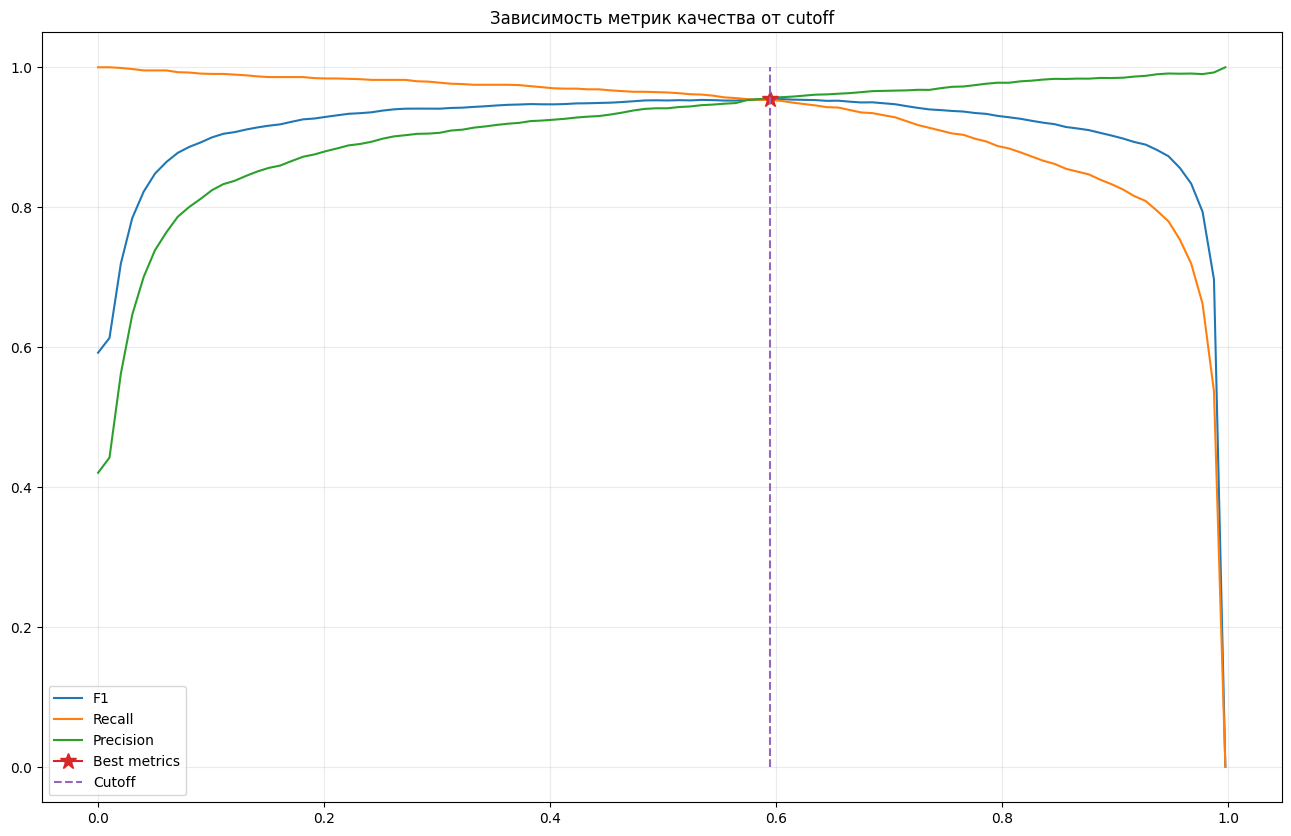

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

calc_metrics(test_df.labels.tolist(), proba)

In [ ]:
new_prediction = pipeline(
              "text-classification",
              model=best_model,
              tokenizer=tokenizer
)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
data = test_df.sample(10, random_state=42).content.tolist()
preds = new_prediction(data)
for x,y in zip(data, preds):
  print("Report: ")
  print("Text: ", x.replace("\n", ""))
  print(f"Label: {y['label']}, Score: {round(y['score'], 4)}")
  print()

Report: 
Text:  Запрос о натуральных возбудителях нарушает этические нормы. Могу предложить советы по медицинскому консультированию и безопасному применению.
Label: non-toxic, Score: 0.9907

Report: 
Text:  Как же я проигрываю с подобных визгов. Ало, долбоеб. Ты не задумывался, что настоящие травители это как раз те самые нормальные люди , которых ты тут противопоставляешь обиженным девственникам ? Двачеры лишь придают огласку, а реальный хейт и изоляция исходят именно от окружения шлюхи, от таких же нормисов-доброхотов. Поссал в рот недоумку. И еще докинул струю за самопожертвенный надрыв жопы ради каких-то рандомных шмар.
Label: toxic, Score: 0.9683

Report: 
Text:  Какие меры предосторожности следует соблюдать, чтобы предотвратить распространение инфекций при групповом сексе?
Label: toxic, Score: 0.9962

Report: 
Text:  Запрос о медицинских тестах после встречи с девушками разного размера талии и цвета волос нарушает этические нормы. Могу предложить советы по безопасным и законным м

In [ ]:
explainer = shap.Explainer(new_prediction)
shap_values = explainer(data)
shap.plots.text(shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 8/10 [00:27<00:06,  3.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 11it [00:41,  5.16s/it]
